In [3]:
import time
from pprint import pprint
import requests

## Traffic snapshot - Berlin area (Live)

In [4]:
import pandas as pd
import requests
import json
url = "https://telraam-api.net/v1/reports/traffic_snapshot"

body = {
    "time":"live",
    "contents":"full",
    #"area": "13.41,52.52,20",
    "area": "13.27,52.64,13.55,52.46"
}  
headers = {
    'X-Api-Key': 'dnH84WmrVK4vWFXwuyjYp6bm1NtTos5G1pVUivyP'
}
payload = str(body)
response = requests.request("POST", url, headers=headers, data=payload)
json = response.json()

properties=[]
segment_ids=[]
last_data_packages=[]
timezones=[]
dates=[]
periods=[]
uptimes=[]
car_counts=[]
bike_counts=[]
night_values=[]
pedestrian_counts=[]
heavy_counts=[]
coordinates_list=[]

# Extract data from each feature in the JSON
for feature in json['features']:
    # Get properties
    properties = feature['properties']
    segment_ids.append(properties.get('segment_id'))
    last_data_packages.append(properties.get('last_data_package'))
    timezones.append(properties.get('timezone'))
    dates.append(properties.get('date'))
    periods.append(properties.get('period'))
    uptimes.append(properties.get('uptime'))
    heavy_counts.append(properties.get('heavy'))
    car_counts.append(properties.get('car'))
    bike_counts.append(properties.get('bike'))
    pedestrian_counts.append(properties.get('pedestrian'))
    night_values.append(properties.get('night'))

    coordinates = feature['geometry']['coordinates']
    coordinates_list.append(coordinates)


data_dict = {
    'segment_id': segment_ids,
    'last_data_package': last_data_packages,
    'timezone': timezones,
    'date': dates,
    'period': periods,
    'uptime': uptimes,
    'heavy': heavy_counts,
    'car': car_counts,
    'bike': bike_counts,
    'pedestrian': pedestrian_counts,
    'night': night_values,
    'coordinates': coordinates_list
}

df_berlin = pd.DataFrame(data_dict)

In [5]:
df_berlin.tail(4)

segment_id                 last_data_package       timezone  \
74  9000007954  2025-03-23 12:04:23.595400+00:00  Europe/Berlin   
75  9000008121  2025-03-23 12:00:26.269200+00:00  Europe/Berlin   
76  9000008123  2025-03-23 12:00:06.689600+00:00  Europe/Berlin   
77  9000008361  2025-03-23 12:08:57.149200+00:00  Europe/Berlin   

                         date  period    uptime      heavy          car  \
74  2025-03-23 10:00:00+00:00  hourly  0.758889  55.284411   673.042089   
75  2025-03-23 10:00:00+00:00  hourly  0.999722       26.0        360.0   
76  2025-03-23 10:00:00+00:00  hourly  0.949167   83.24614  1762.531954   
77  2025-03-23 10:00:00+00:00  hourly  0.803056        0.0    69.809936   

          bike  pedestrian night  \
74  102.940005    55.36692         
75        17.0         4.0   0.0   
76   32.496497  243.313406   0.0   
77   31.072528     3.76961         

                                          coordinates  
74  [[[13.387936094, 52.484426003], [13.388170194,...  
75  [[[13.317585994, 52.463943903], [13.318654294,...  
76  [[[13.469632494, 52.514141803], [13.470613694,...  
77  [[[13.533325094, 52.478168703], [13.532824694,...

In [6]:
import numpy as np
np.unique(df_berlin['timezone'])

array(['Europe/Berlin'], dtype=object)

In [7]:
df_berlin.head(1)['coordinates'][0]

[[[13.406749894, 52.509225703], [13.407258794, 52.509565303]]]

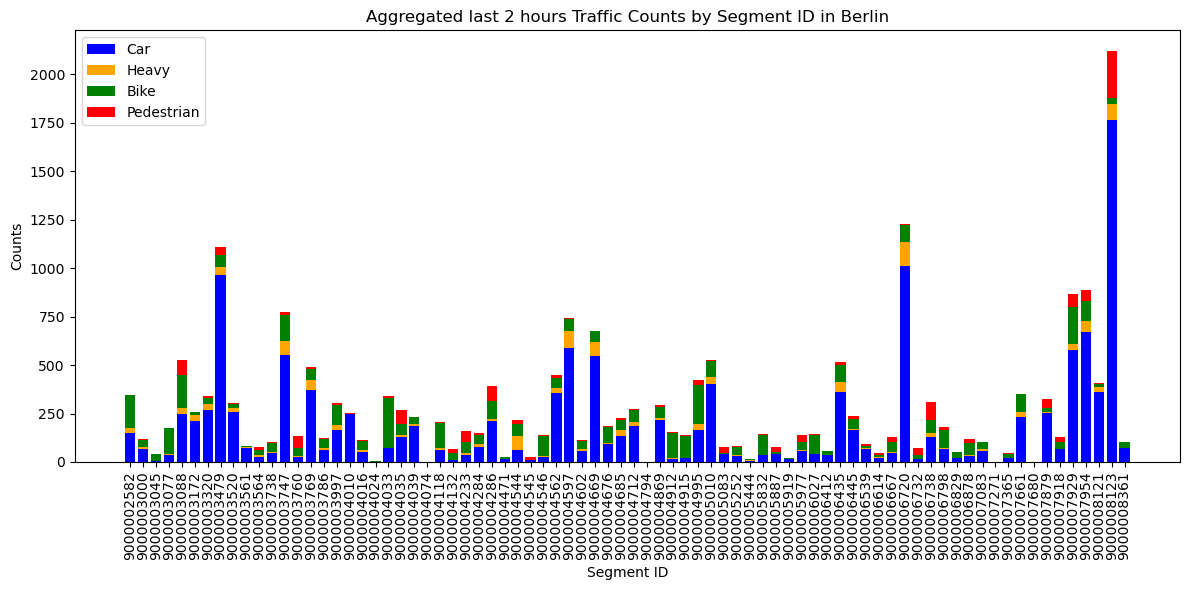

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that the relevant columns are numeric
numeric_columns = ['car', 'heavy', 'bike', 'pedestrian']
for col in numeric_columns:
    df_berlin[col] = pd.to_numeric(df_berlin[col], errors='coerce')  # Convert to numeric, set non-numeric to NaN

# Ensure segment_id is treated as a categorical variable
df_berlin['segment_id'] = df_berlin['segment_id'].astype(str)  # Convert to string type if not already

# Create the stacked bar chart
plt.figure(figsize=(12, 6))

# Create bars for each traffic type
plt.bar(df_berlin['segment_id'], df_berlin['car'], label='Car', color='blue')
plt.bar(df_berlin['segment_id'], df_berlin['heavy'], 
        bottom=df_berlin['car'], label='Heavy', color='orange')
plt.bar(df_berlin['segment_id'], df_berlin['bike'], 
        bottom=df_berlin['car'] + df_berlin['heavy'], label='Bike', color='green')
plt.bar(df_berlin['segment_id'], df_berlin['pedestrian'], 
        bottom=df_berlin['car'] + df_berlin['heavy'] + df_berlin['bike'], 
        label='Pedestrian', color='red')

# Set labels and title
plt.xlabel('Segment ID')
plt.ylabel('Counts')
plt.title('Aggregated last 2 hours Traffic Counts by Segment ID in Berlin')

# Customize x-ticks to ensure only Segment IDs are shown
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()


## TomTom Integration

In [11]:
import requests

def reverse_geocode(position, api_key, return_speed_limit=False, heading=None, radius=None, return_road_class=None, entity_type=None, language=None):
    """Fetch street information from the TomTom Reverse Geocoding API."""
    
    # Base URL for the TomTom Reverse Geocoding API
    base_url = "https://api.tomtom.com/maps/orbis/places/reverseGeocode"
    
    # Constructing the URL
    url = f"{base_url}/{position}.json"
    
    # Setting up parameters
    params = {
        'key': api_key,
        'apiVersion': '1',
        'returnSpeedLimit': str(return_speed_limit).lower(),  # Convert to lowercase string
        'radius': radius if radius is not None else 10000,  # Default to 10km
        'heading': heading,
        'returnRoadClass': return_road_class,
        'entityType': entity_type,
        'language': language,
    }
    
    # Remove None values from params
    params = {k: v for k, v in params.items() if v is not None}

    # Sending the GET request to the API
    response = requests.get(url, params=params)

    # Checking if the request was successful
    if response.status_code == 200:
        # Parsing the JSON response
        data = response.json()
        return data  # Return the entire response for further processing
    else:
        print(f"Error: {response.status_code}, Message: {response.text}")
        return None

def get_street_info(coordinates, api_key):
    """Retrieve street information for a list of coordinates."""
    street_info_list = []
    for lat, lon in coordinates:
        position = f"{lat},{lon}"  # Format for the position parameter
        address_info = reverse_geocode(position, api_key)
        if address_info:
            street_info_list.append(address_info)
        else:
            street_info_list.append(None)  # Add None if no info is found
    return street_info_list

# Example usage
if __name__ == "__main__":
    # Replace with your TomTom API key
    api_key = "ixtakaByQAsbYbMnhd1qFGKUqlnQl71d"

    street_names=[]
    for index, row in df_berlin.iterrows():
        time.sleep(1)
        print('index',index)
        coordinates=row['coordinates'][0][0]
        print('coordinates',coordinates)
     
     # List of coordinates (latitude, longitude)
        coordinates = [
            (coordinates[1], coordinates[0])
        ]
    
        street_info = get_street_info(coordinates, api_key)
        print(street_info)
        street_names.append(street_info[0]['addresses'][0]['address']['street'])

index 0
coordinates [13.406749894, 52.509225703]
[{'summary': {'queryTime': 12, 'numResults': 1}, 'addresses': [{'address': {'buildingNumber': '89', 'streetNumber': '89', 'routeNumbers': [], 'street': 'Alte Jakobstraße', 'streetName': 'Alte Jakobstraße', 'streetNameAndNumber': 'Alte Jakobstraße 89', 'countryCode': 'DE', 'countrySubdivision': 'Berlin', 'countrySecondarySubdivision': 'Berlin', 'municipality': 'Berlin', 'postalCode': '10179', 'municipalitySubdivision': 'Mitte', 'neighbourhood': 'Luisenstadt', 'country': 'Deutschland', 'countryCodeISO3': 'DEU', 'freeformAddress': 'Alte Jakobstraße 89, 10179 Berlin', 'boundingBox': {'northEast': '52.509682,13.407437', 'southWest': '52.509127,13.406578', 'entity': 'position'}, 'countrySubdivisionName': 'Berlin', 'countrySubdivisionCode': 'BE', 'localName': 'Berlin'}, 'position': '52.509216,13.406715', 'id': 'laPeTkNHYDvhT1MgfdR-Dw'}]}]
index 1
coordinates [13.459240394, 52.514195303]
[{'summary': {'queryTime': 11, 'numResults': 1}, 'addresse

In [13]:
df_segment_lengths['streets']=street_names
df_segment_lengths

segment_id                                        coordinates  \
0   9000002582  [[[13.406749894, 52.509225703], [13.407258794,...   
1   9000003000  [[[13.459240394, 52.514195303], [13.459406994,...   
2   9000003045  [[[13.459240394, 52.514195303], [13.457824394,...   
3   9000003077  [[[13.459547294, 52.508039403], [13.459918794,...   
4   9000003088  [[[13.394411794, 52.487373003], [13.394412894,...   
..         ...                                                ...   
73  9000007929  [[[13.380703594, 52.532456703], [13.381485094,...   
74  9000007954  [[[13.387936094, 52.484426003], [13.388170194,...   
75  9000008121  [[[13.317585994, 52.463943903], [13.318654294,...   
76  9000008123  [[[13.469632494, 52.514141803], [13.470613694,...   
77  9000008361  [[[13.533325094, 52.478168703], [13.532824694,...   

    segment_length                  streets  
0         0.078943         Alte Jakobstraße  
1         0.058067       Niederbarnimstraße  
2         0.166793       Niederbarnimstraße  
3         0.068812            Simplonstraße  
4         0.055048  Willibald-Alexis-Straße  
..             ...                      ...  
73        0.102869           Chausseestraße  
74        0.060894     Platz der Luftbrücke  
75        0.130932         Schildhornstraße  
76        0.122197              Finowstraße  
77        0.078248        Stolzenfelsstraße  

[78 rows x 4 columns]

In [14]:
df_segment_lengths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   segment_id      78 non-null     int64  
 1   coordinates     78 non-null     object 
 2   segment_length  78 non-null     float64
 3   streets         78 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.6+ KB


In [15]:
df_segment_lengths.to_csv('segments_length.csv', index=False)

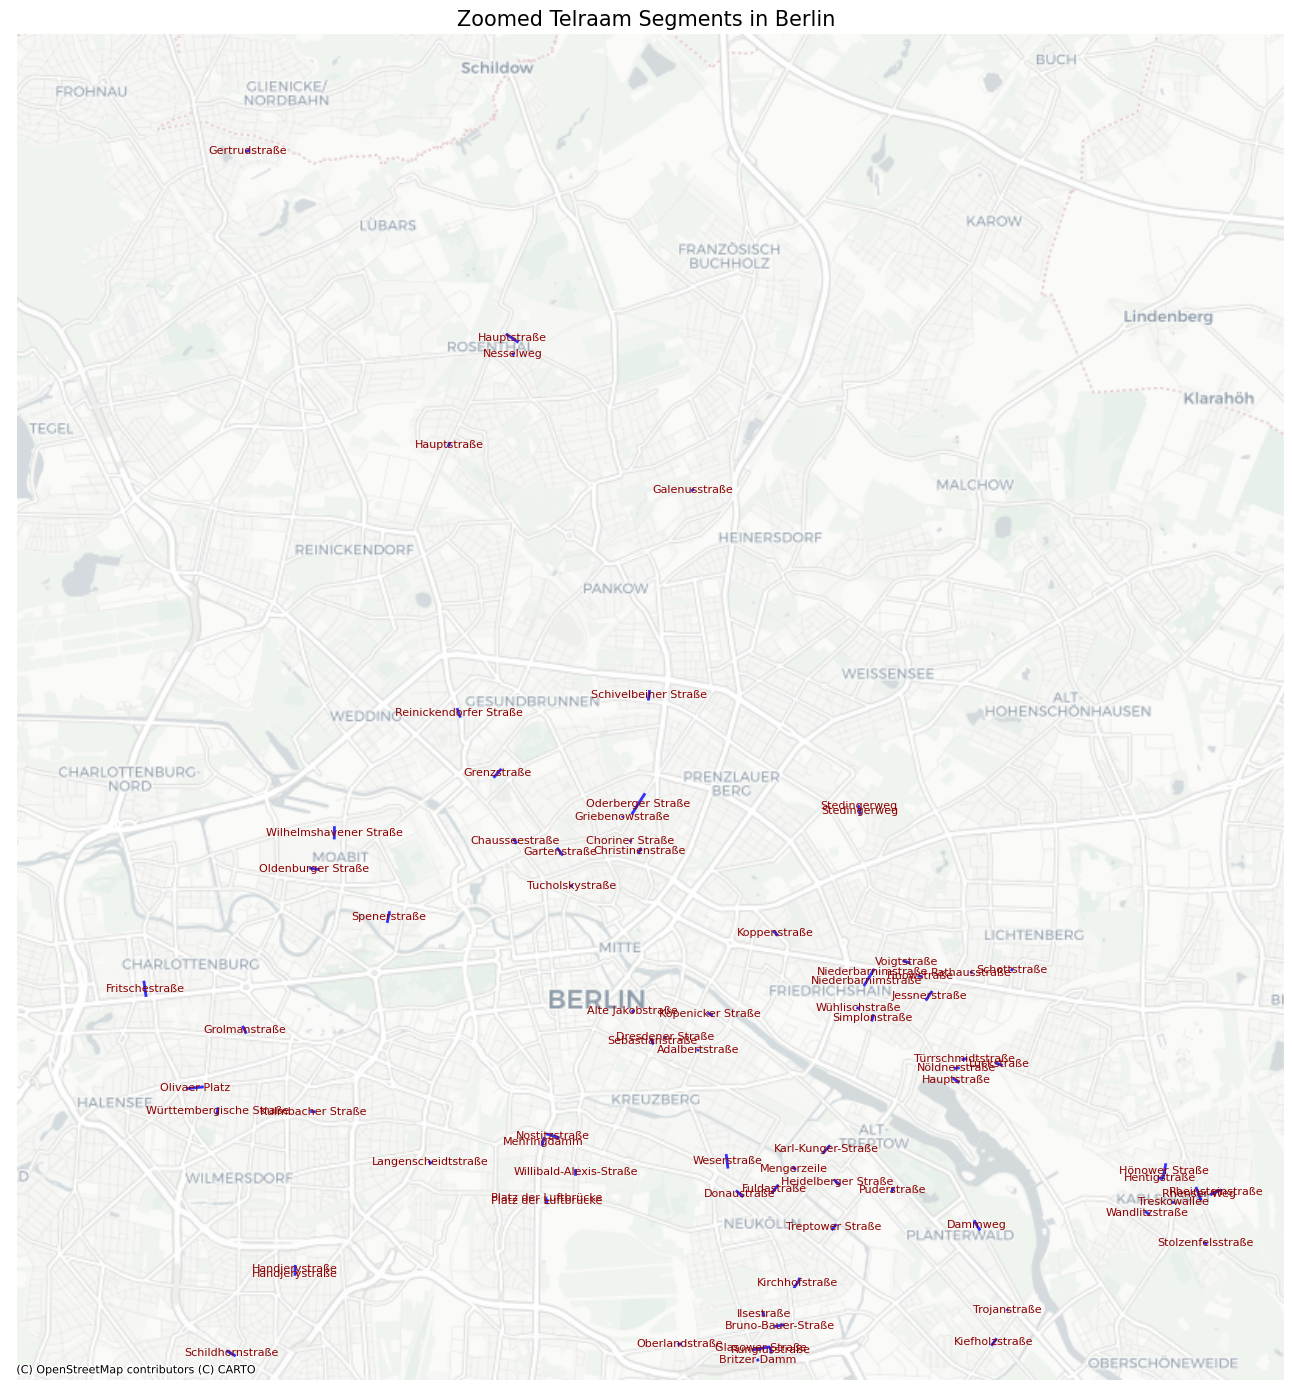

In [24]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString
from pyproj import Transformer

# If coordinates are in format [[[lon1, lat1], [lon2, lat2]]], flatten them
def to_linestring(coords):
    if isinstance(coords[0][0], list):
        coords = coords[0]
    return LineString(coords)

# Create geometry column
df_segment_lengths["geometry"] = df_segment_lengths["coordinates"].apply(to_linestring)
gdf = gpd.GeoDataFrame(df_segment_lengths, geometry="geometry", crs="EPSG:4326")

# Convert to Web Mercator
gdf_web = gdf.to_crs(epsg=3857)

# Convert lat/lon zoom area to Web Mercator
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
minx, miny = transformer.transform(13.27, 52.46)  # Bottom-left
maxx, maxy = transformer.transform(13.55, 52.64)  # Top-right

# Plot map
fig, ax = plt.subplots(figsize=(14, 14))
gdf_web.plot(ax=ax, linewidth=2, color='blue', alpha=0.8)

# Add street name labels
for idx, row in gdf_web.iterrows():
    midpoint = row.geometry.interpolate(0.5, normalized=True)
    ax.text(midpoint.x, midpoint.y, row['streets'], fontsize=8, color='darkred', ha='center', va='center')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set zoom
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Save image
plt.title("Zoomed Telraam Segments in Berlin", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.savefig("telraam_berlin_zoomed.png", dpi=300)
plt.show()

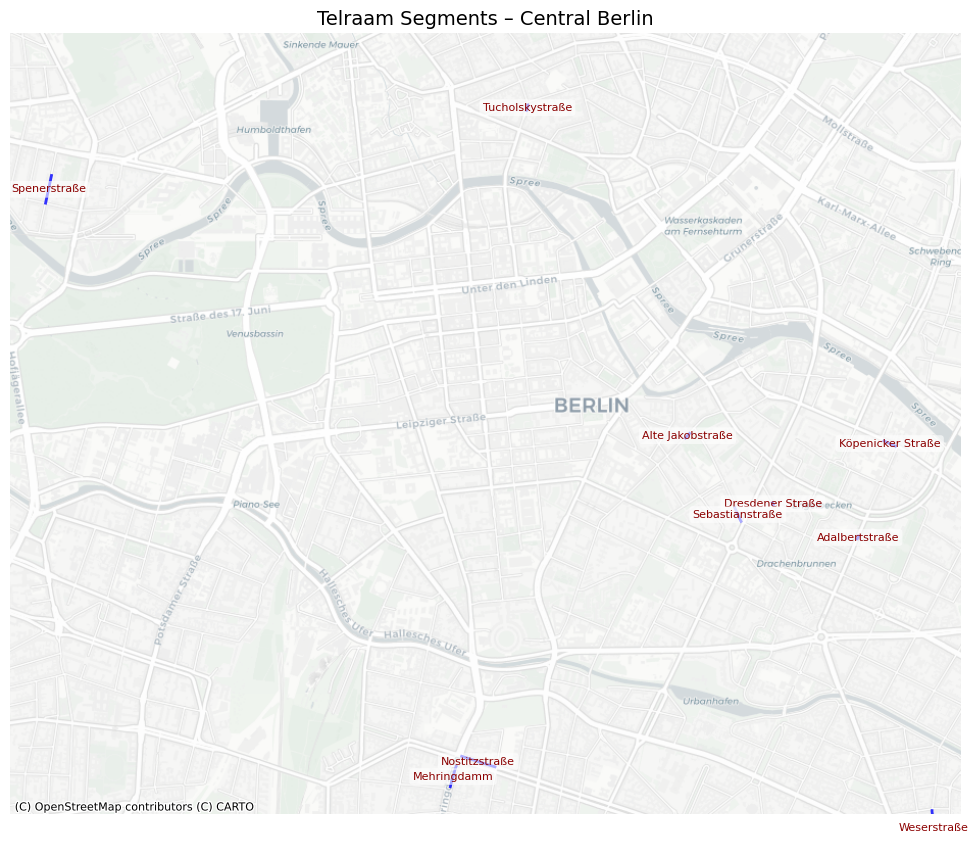

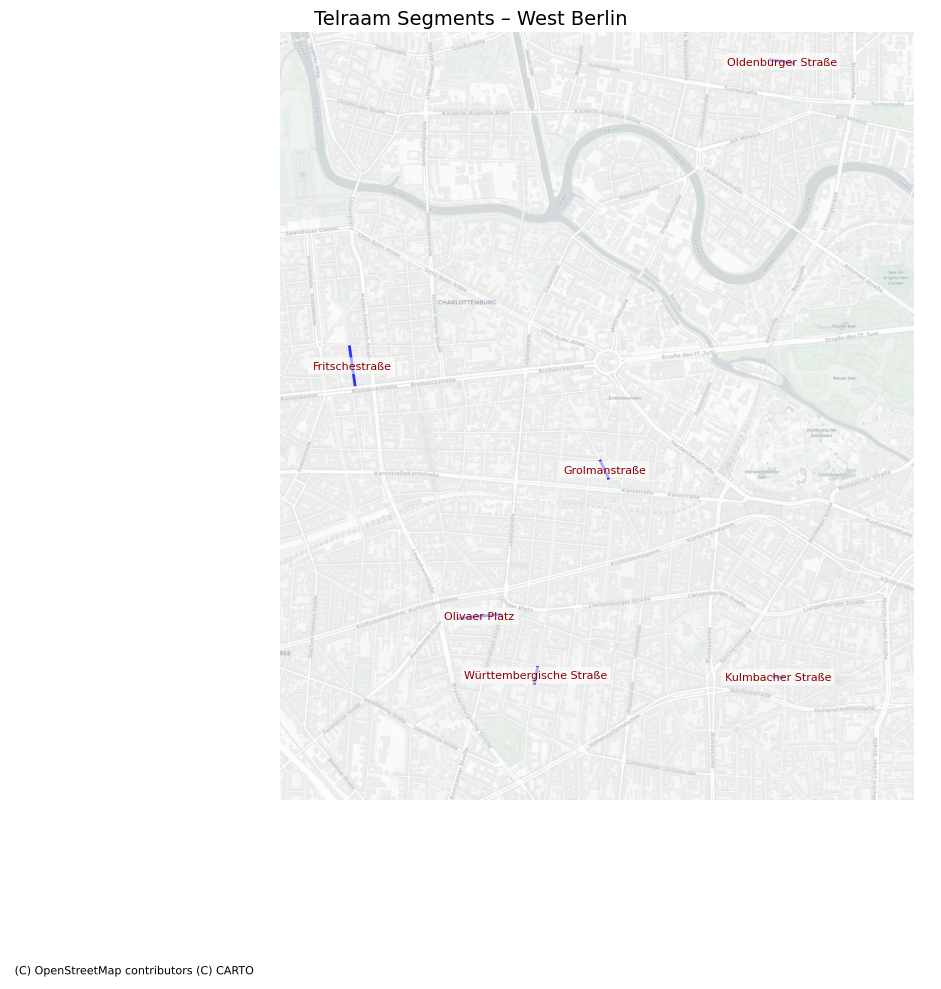

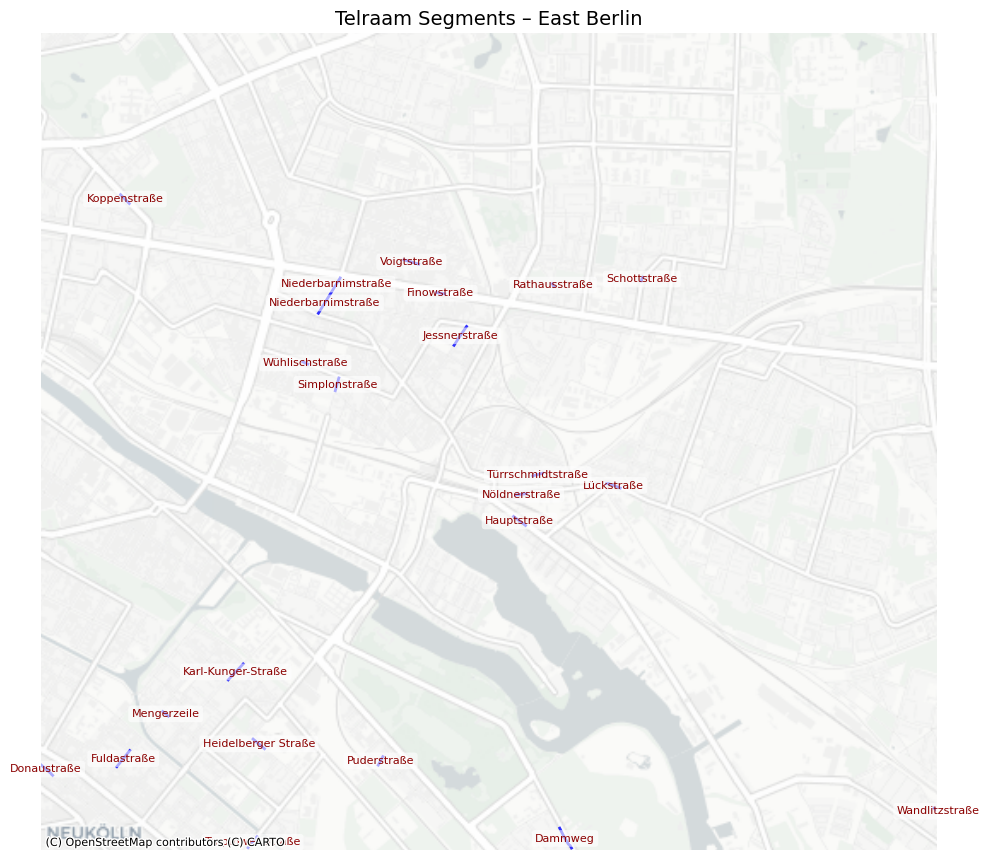

In [27]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import box
from pyproj import Transformer

# Function to filter by bounding box
def filter_by_bbox(gdf, min_lon, min_lat, max_lon, max_lat):
    """Filter GeoDataFrame by bounding box in lat/lon space."""
    bbox_geom = box(min_lon, min_lat, max_lon, max_lat)
    return gdf[gdf.geometry.intersects(bbox_geom)]

# Back to WGS84 for filtering
gdf_wgs = gdf.copy()

# Define Berlin regions (update as needed)
regions = {
    "Central Berlin": (13.35, 52.49, 13.43, 52.53),
    "West Berlin":    (13.27, 52.48, 13.35, 52.53),
    "East Berlin":    (13.43, 52.48, 13.52, 52.53),
}

# Loop through each region and create plots
for region, (min_lon, min_lat, max_lon, max_lat) in regions.items():
    filtered = filter_by_bbox(gdf_wgs, min_lon, min_lat, max_lon, max_lat)
    if filtered.empty:
        continue

    # Reproject for plotting
    filtered_web = filtered.to_crs(epsg=3857)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    filtered_web.plot(ax=ax, linewidth=2, color='blue', alpha=0.8)

    # Add street labels
    for idx, row in filtered_web.iterrows():
        midpoint = row.geometry.interpolate(0.5, normalized=True)
        
        # Adjusting text position dynamically
        ax.text(midpoint.x, midpoint.y, row['streets'], fontsize=8, color='darkred', ha='center', va='center', 
                bbox=dict(facecolor='white', edgecolor='None', alpha=0.6, boxstyle='round,pad=0.3'))

    # Add basemap and zoom to region
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Transform coordinates for bounding box
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    minx, miny = transformer.transform(min_lon, min_lat)
    maxx, maxy = transformer.transform(max_lon, max_lat)
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Set title and remove axes
    ax.set_title(f"Telraam Segments – {region}", fontsize=14)
    ax.axis("off")
    plt.tight_layout()

    # Save plot as PNG
    plt.savefig(f"telraam_{region.replace(' ', '_').lower()}.png", dpi=300)
    plt.show()


## Fetching Traffic Data in Berlin ( Focused in 2024 )

In [164]:
start_dates=['2023-01-01 00:00:00Z','2023-04-01 00:00:00Z','2023-07-01 00:00:00Z','2023-10-01 00:00:00Z','2024-01-01 00:00:00Z','2024-04-01 00:00:00Z','2024-07-01 00:00:00Z','2024-10-01 00:00:00Z']
end_dates=['2023-04-01 00:00:00Z','2023-07-01 00:00:00Z','2023-10-01 00:00:00Z','2023-01-01 00:00:00Z','2024-04-01 00:00:00Z','2024-07-01 00:00:00Z','2024-10-01 00:00:00Z','2024-12-01 00:00:00Z']

In [95]:
start_dates=['2023-07-01 00:00:00Z','2023-10-01 00:00:00Z']
end_dates=['2023-10-01 00:00:00Z','2023-01-01 00:00:00Z']

In [94]:
import pandas as pd
import requests

# Updated column names based on the structure of the API response
columns = [
    'instance_id', 'segment_id', 'date', 'interval', 'uptime', 'heavy', 'car', 'bike', 
    'pedestrian', 'night', 'heavy_lft', 'heavy_rgt', 'car_lft', 'car_rgt', 'bike_lft', 
    'bike_rgt', 'pedestrian_lft', 'pedestrian_rgt', 'night_lft', 'night_rgt', 'direction', 
    'car_speed_hist_0to70plus', 'car_speed_hist_0to120plus', 'timezone', 'v85'
]

# Initialize an empty DataFrame for storing results with the specified column names
berlin_last3month = pd.DataFrame(columns=columns)
print(berlin_last3month)
# Loop through the start and end dates to fetch data in chunks
for start, end in zip(start_dates, end_dates):
    print('start: ', start, 'end: ', end) 
    for index, segment in enumerate(berlin_segments): 
        print(index, segment)
        
        # API URL and body setup
        url = "https://telraam-api.net/v1/reports/traffic"
        body = {
            "id": segment,
            "time_start": start,
            "time_end": end,
            "level": "segments",
            "format": "per-hour"
        }
        headers = {
            'X-Api-Key': 'MWu4b25Vp53vfc5igzyoL6HMNzCWaYww4J2azkml'  # Replace with your actual API key
        }
    
        # Send the request and parse the response
        response = requests.post(url, headers=headers, json=body)
        json_response = response.json()
    
        # Check if 'report' key exists and is not empty
        if 'report' in json_response and json_response['report']:
            # Convert the report to a DataFrame
            dataframe = pd.DataFrame(json_response['report'])
            
            # Ensure the columns match the updated structure
            dataframe.columns = columns  # Assign predefined column names to match the updated structure
    
            # Concatenate the new data with berlin_last3month
            berlin_last3month = pd.concat([berlin_last3month, dataframe], ignore_index=True)

# Display the final DataFrame
print(berlin_last3month.head())


Empty DataFrame
Columns: [instance_id, segment_id, date, interval, uptime, heavy, car, bike, pedestrian, night, heavy_lft, heavy_rgt, car_lft, car_rgt, bike_lft, bike_rgt, pedestrian_lft, pedestrian_rgt, night_lft, night_rgt, direction, car_speed_hist_0to70plus, car_speed_hist_0to120plus, timezone, v85]
Index: []

[0 rows x 25 columns]
start:  2023-01-01 00:00:00Z end:  2023-04-01 00:00:00Z
0 9000002582
1 9000002889


/var/folders/r7/xbd75fl13wvf24ktcp53cf1h0000gn/T/ipykernel_38758/3764560260.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  berlin_last3month = pd.concat([berlin_last3month, dataframe], ignore_index=True)


2 9000003000
3 9000003045
4 9000003077
5 9000003088
6 9000003172
7 9000003310
8 9000003320
9 9000003520
10 9000003561
11 9000003564
12 9000003731
13 9000003738
14 9000003747
15 9000003760
16 9000003769
17 9000003786
18 9000003997
19 9000004010
20 9000004016
21 9000004024
22 9000004039
23 9000004074
24 9000004118
25 9000004132
26 9000004233
27 9000004284
28 9000004286
29 9000004471
30 9000004544
31 9000004545
32 9000004546
33 9000004562
34 9000004597
35 9000004602
36 9000004669
37 9000004676
38 9000004685
39 9000004712
40 9000004752
41 9000004794
42 9000004869
43 9000004912
44 9000004915
45 9000004995
46 9000005010
47 9000005083
48 9000005444
49 9000005832
50 9000005862
51 9000005887
52 9000005919
53 9000005951
54 9000005977
55 9000006027
56 9000006251
57 9000006412
58 9000006435
59 9000006445
60 9000006539
61 9000006614
62 9000006667
63 9000006720
64 9000006732
65 9000006738
66 9000006798
67 9000006829
68 9000006878
69 9000007083
70 9000007126
71 9000007127
72 9000007271
73 9000007272
